In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

In [4]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Adesao'

porte_operadora = 'Médio'

tipo_modalidade = 'Cooperativa Médica'

## Leitura dos dados

In [5]:
path = f'D:/TCC/TCC/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

ans = ans[(ans.ano > '2017') & (ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200,0.000,722.000,0.0,0.0
1,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340,0.000,731.000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020,0.000,774.000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2018,2018Q4,903017.550,0.000,787.000,0.0,0.0
4,2019,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2019,2019Q2,1801080.840,0.000,775.000,0.0,0.0


In [6]:
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade) &
                              (ans_filt['port_ops'] == porte_operadora)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q1,497251.970,276607.160,553.000
1,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q2,735076.440,550612.960,559.000
2,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q3,733381.570,691165.860,552.000
3,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q4,761232.710,765260.320,915.000
4,2020,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2020Q1,865752.710,855869.210,1015.000


In [7]:
ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita  despesa
ano  cd_ops razao_social                                     trimestre                  
2018 300713 UNIMED DE ASSIS COOPERATIVA DE TRABALHO MÉDICO   2018Q1       2.960    1.410
                                                             2018Q2       2.230    1.820
                                                             2018Q3       1.410    2.350
                                                             2018Q4       2.320    1.450
     301574 UNIMED DE LIMEIRA COOPERATIVA DE TRABALHO MÉDICO 2018Q1       3.560    3.580

In [8]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                               'despesa':lambda x: sum_million(x),
                                                                                               'benef': 'sum',
                                                                                               'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['pct_despesa'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q4') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

#ans_filt_cont_mod_agrup['trimestre'] = pd.PeriodIndex(ans_filt_cont_mod_agrup['trimestre'], freq="Q")

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,526.250,414.620,594023,97,78.790
2018Q2,552.370,460.660,620820,98,83.400
2018Q3,585.540,493.280,628285,99,84.240
2018Q4,736.030,479.840,608198,97,65.190
2019Q1,641.030,490.160,649913,100,76.460
2019Q2,654.480,559.290,646728,101,85.460
2019Q3,722.920,634.330,651336,101,87.750
2019Q4,684.730,606.040,644093,102,88.510
2020Q1,686.430,542.090,635076,101,78.970


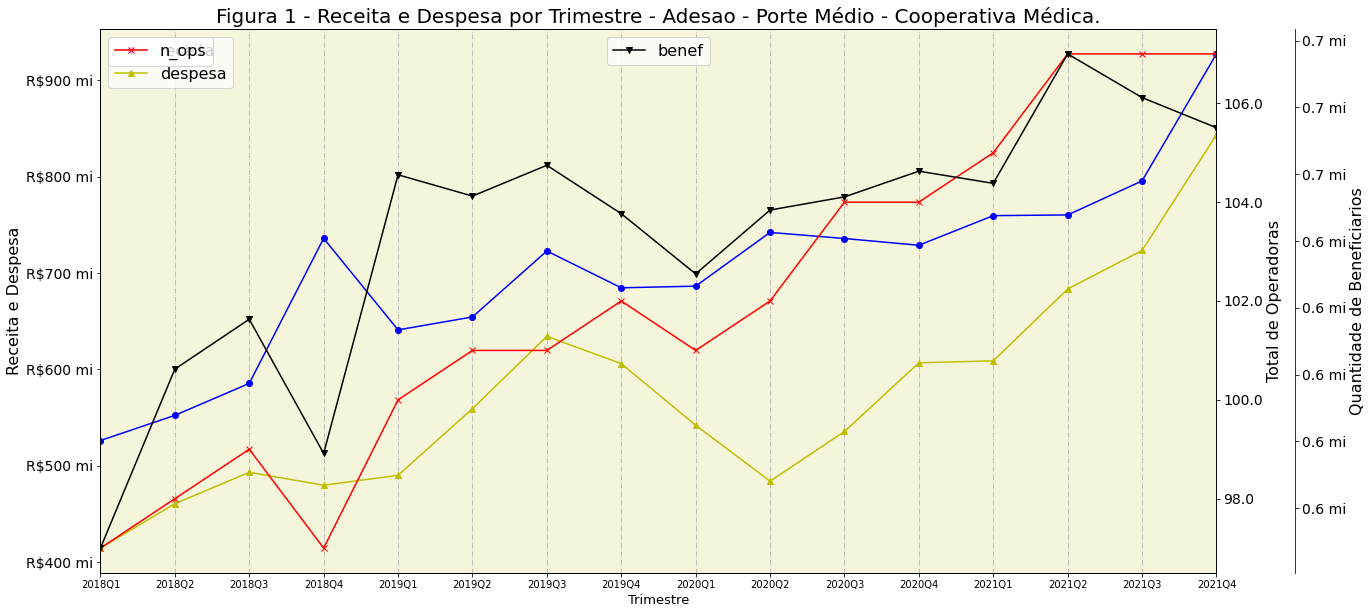

In [9]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesao - Porte Médio - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1000000) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [10]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                         'despesa':lambda x: sum_million(x),
                                                                                                         'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index()

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,index,ano,cd_ops,trimestre,receita,despesa,benef
0,192,2018,335479,2018Q2,43.440,42.190,42435.000
1,191,2018,335479,2018Q1,41.730,31.440,41321.000
2,193,2018,335479,2018Q3,44.800,49.560,41006.000
3,194,2018,335479,2018Q4,47.600,66.630,38973.000
4,585,2019,335479,2019Q1,48.670,43.370,37486.000


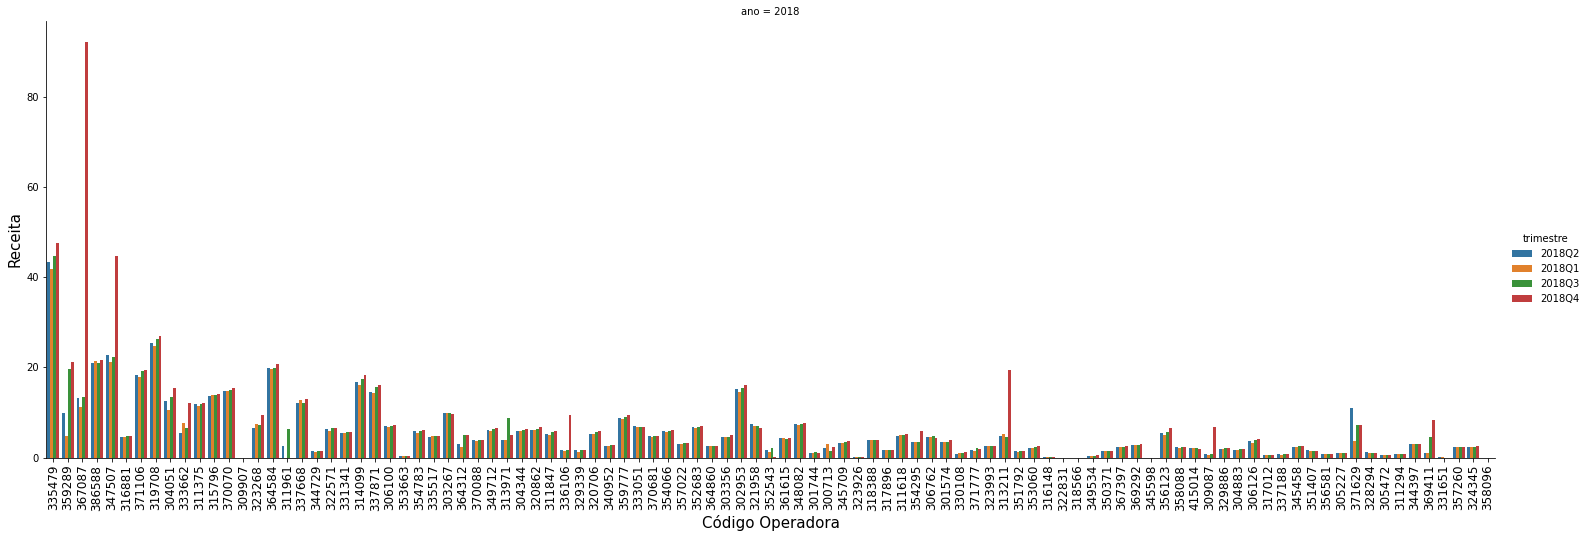

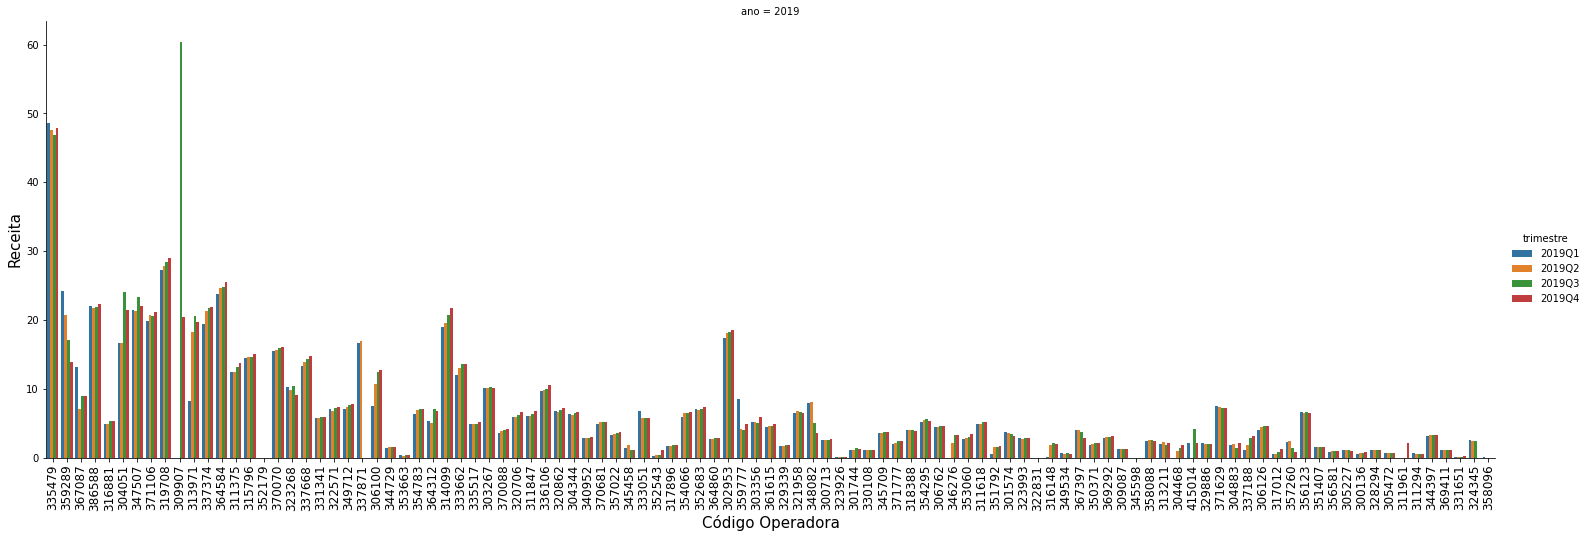

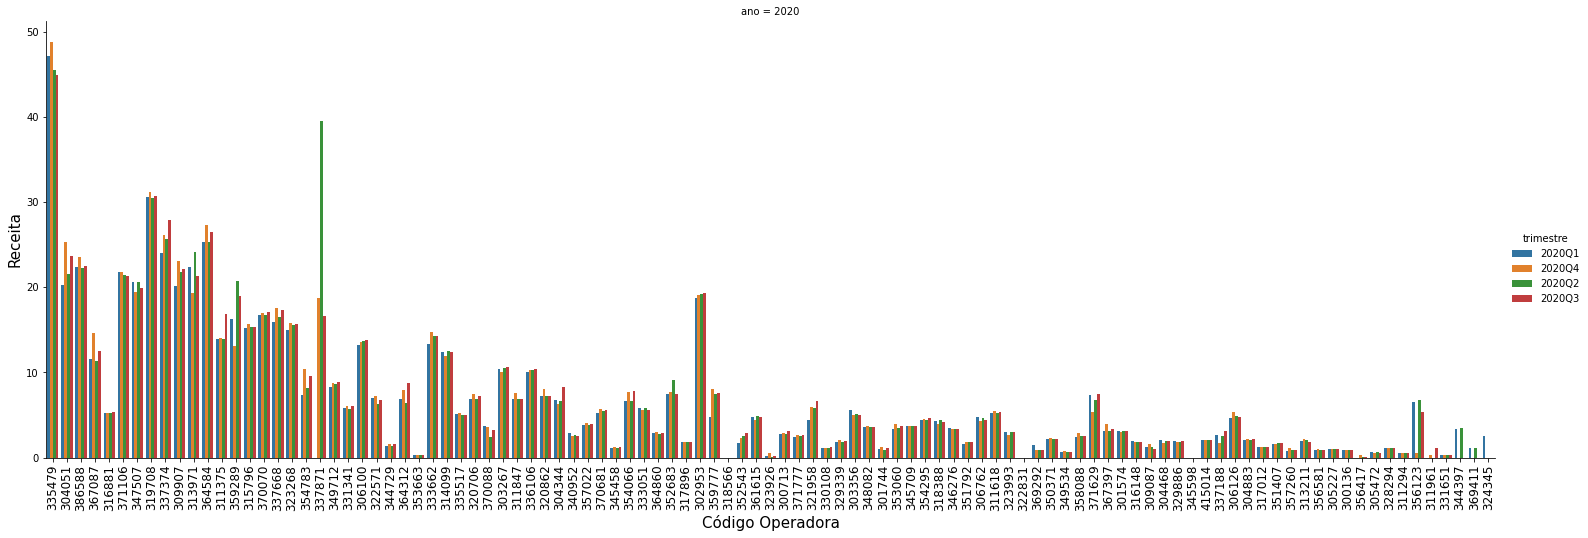

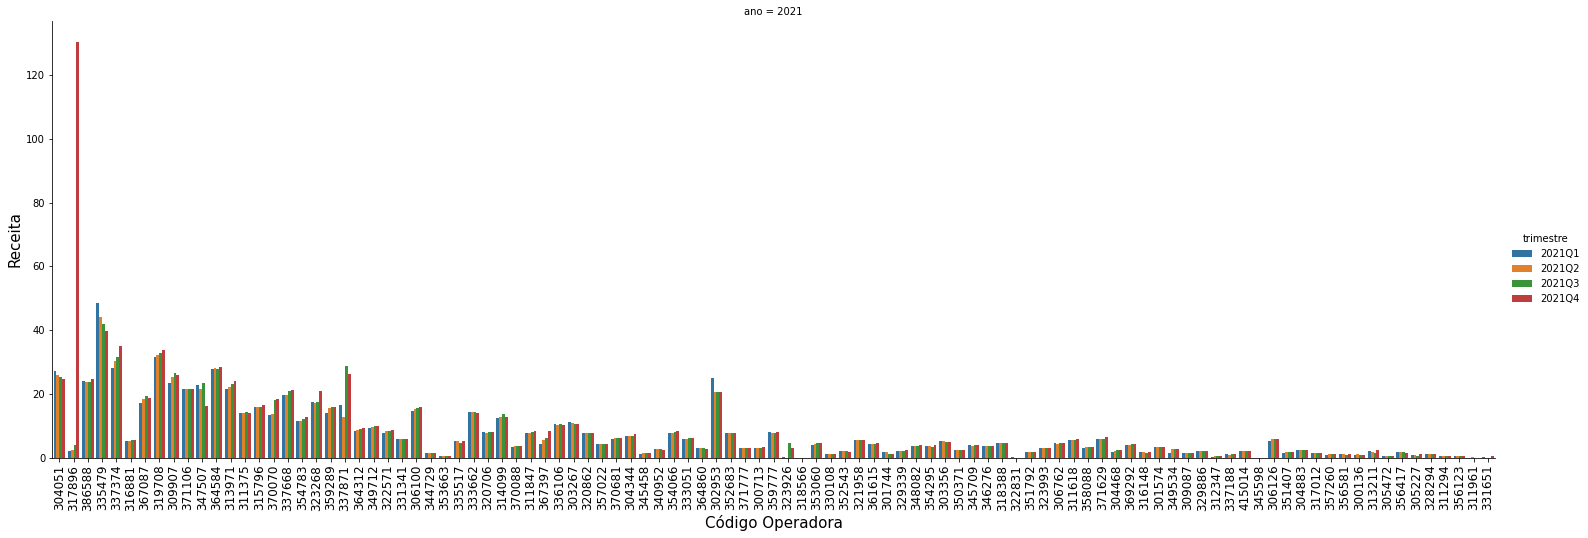

In [11]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

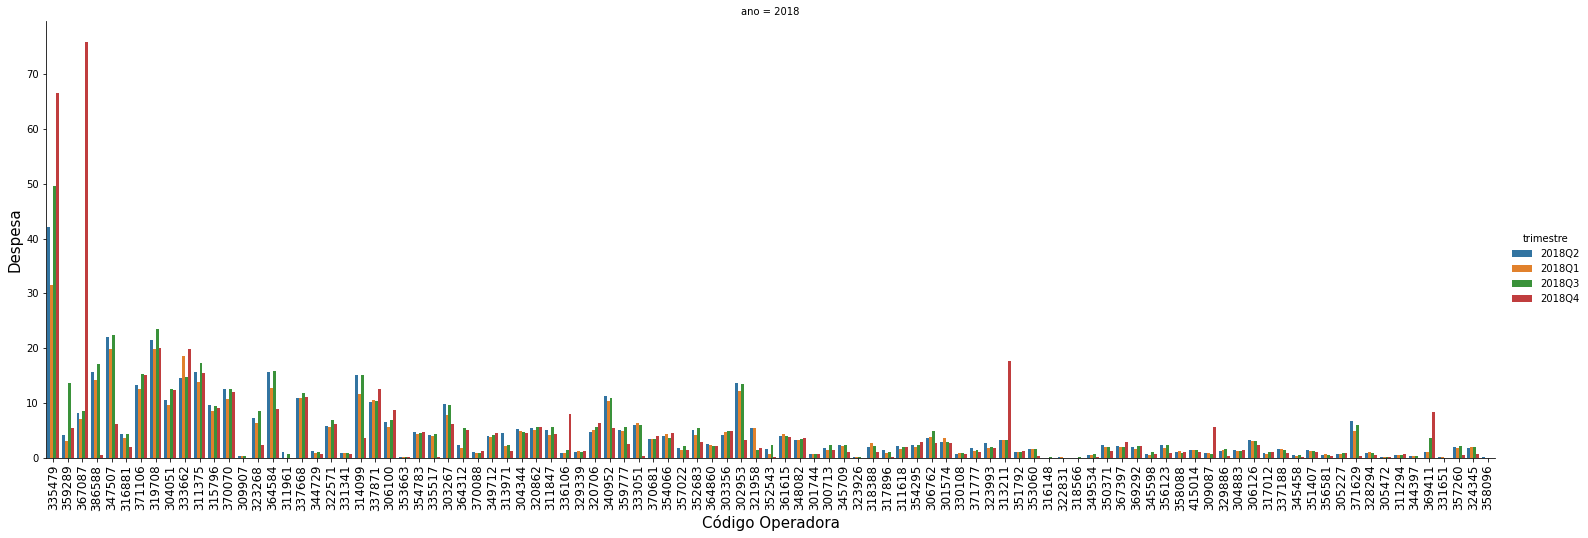

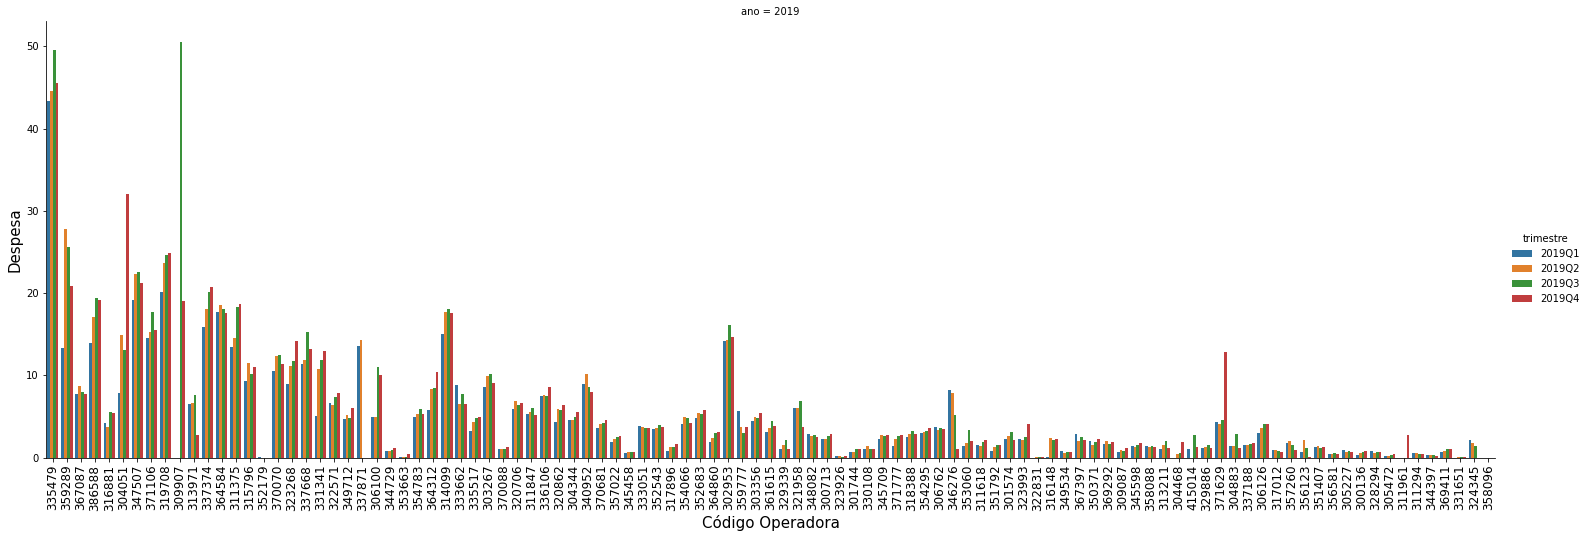

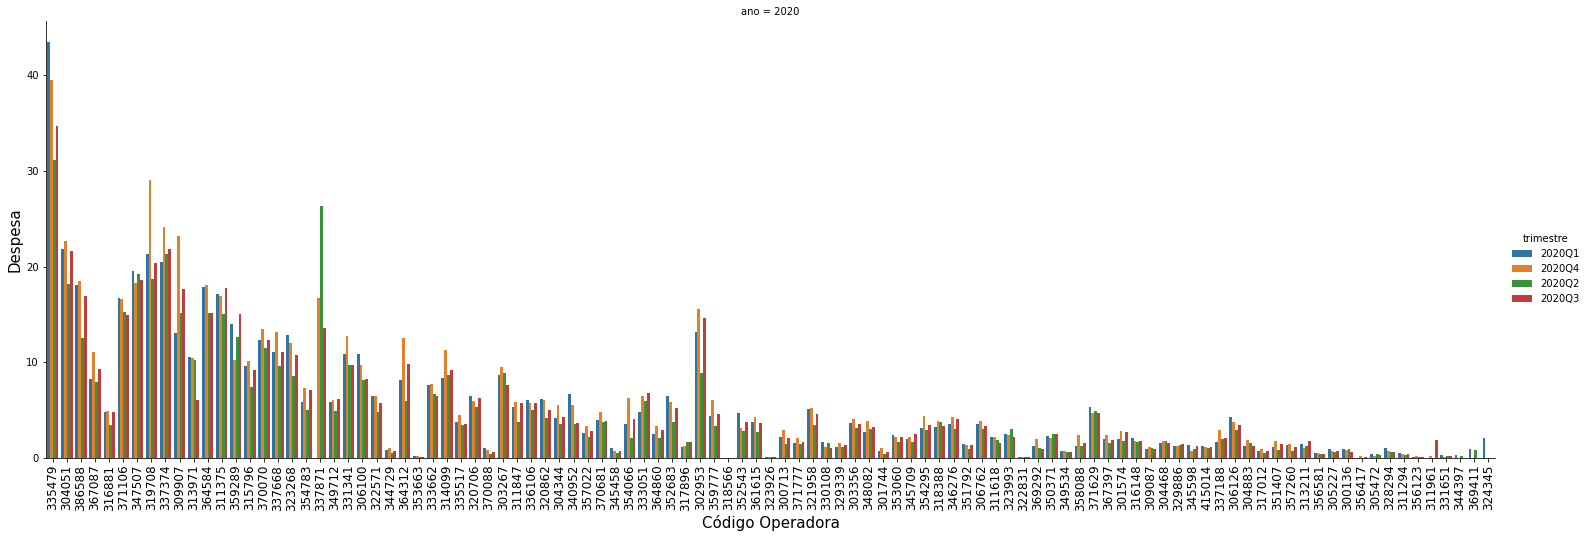

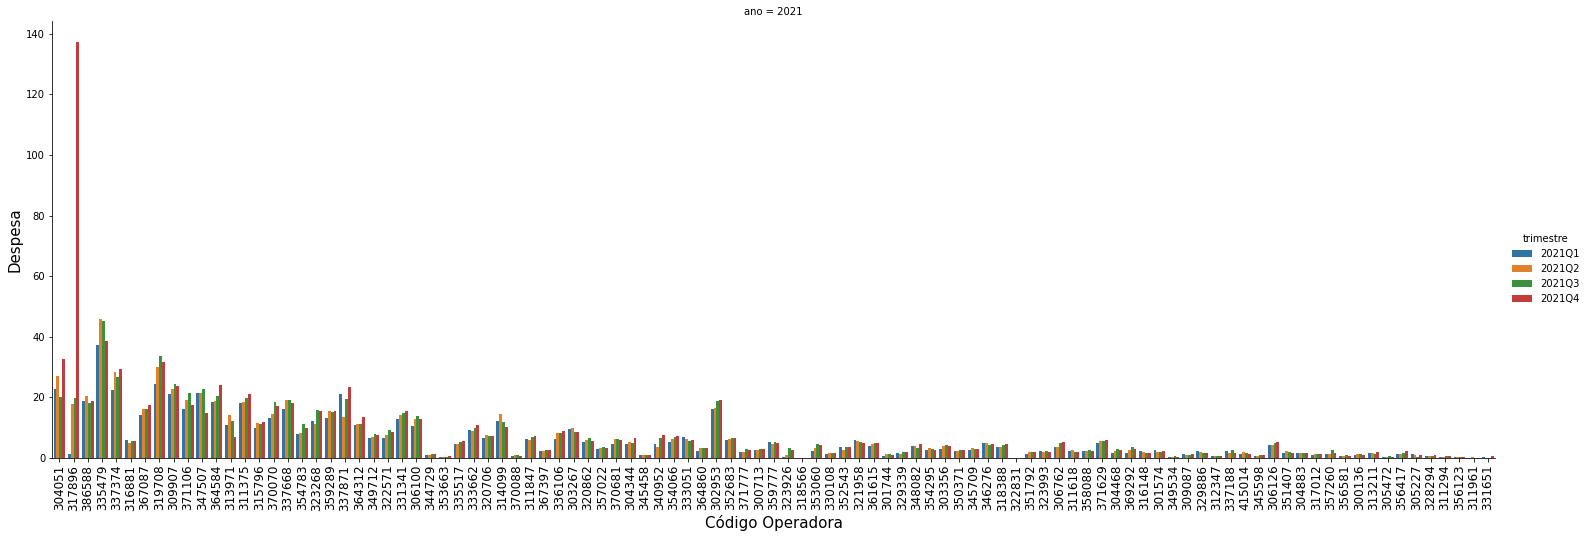

In [12]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Limpeza e Tratamento de Dados

In [13]:
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.620,1405863.510
1,2018,300713,2018Q2,2231365.780,1820915.150
2,2018,300713,2018Q3,1406682.200,2351203.340
3,2018,300713,2018Q4,2321841.790,1453821.050
4,2018,301574,2018Q1,3559709.440,3584395.420


In [14]:
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

#ans_alterada2.n_trimestre.unique()

ans_alterada2.head()

,ano,cd_ops,n_trimestre
0,2018,300713,4
1,2018,301574,4
2,2018,301744,4
3,2018,302953,4
4,2018,303267,4


In [15]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]
display(ans_alterada_complete.head())

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

,ano,cd_ops
0,2018,300713
1,2018,301574
2,2018,301744
3,2018,302953
4,2018,303267


In [16]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]
display(ans_alterada_imcomplete.head())

imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

,ano,cd_ops
0,2018,311961
1,2019,304468
2,2019,309907
3,2019,311961
4,2019,337871


In [17]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

ans_alterada_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 387
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     378 non-null    period[A-DEC]
 1   cd_ops  378 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 8.9+ KB


In [18]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#diops_tcc_analise3[diops_tcc_analise3['receita']==0]

display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.620,1405863.510
1,2018,300713,2018Q2,2231365.780,1820915.150
2,2018,300713,2018Q3,1406682.200,2351203.340
3,2018,300713,2018Q4,2321841.790,1453821.050
4,2018,301574,2018Q1,3559709.440,3584395.420


array([4], dtype=int64)

In [19]:
#Cálculo do percentual de crescimento entre os trimestres
ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
0,2018,300713,2018Q1,2962073.620,0.000,0.000,1405863.510,0.000,0.000
1,2018,300713,2018Q2,2231365.780,2962073.620,0.753,1820915.150,1405863.510,1.295
2,2018,300713,2018Q3,1406682.200,2231365.780,0.630,2351203.340,1820915.150,1.291
3,2018,300713,2018Q4,2321841.790,1406682.200,1.651,1453821.050,2351203.340,0.618
4,2018,301574,2018Q1,3559709.440,0.000,0.000,3584395.420,0.000,0.000


In [20]:
stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000,0.000,0.000,0.000
1,2018,2018Q2,0.993,1.055,0.974,1.217
2,2018,2018Q3,1.000,1.052,0.954,1.131
3,2018,2018Q4,1.005,1.072,0.447,1.085
4,2019,2019Q1,0.000,0.000,0.000,0.000
5,2019,2019Q2,0.994,1.062,0.996,1.227
6,2019,2019Q3,1.002,1.040,0.971,1.197
7,2019,2019Q4,0.994,1.038,0.891,1.108
8,2020,2020Q1,0.000,0.000,0.000,0.000
9,2020,2020Q2,0.989,1.037,0.687,0.933


In [21]:
ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,300713,2018Q1,2962073.620,0.000,0.000,1405863.510,0.000,0.000,0.000,0.000,0.000,0.000
4,2018,301574,2018Q1,3559709.440,0.000,0.000,3584395.420,0.000,0.000,0.000,0.000,0.000,0.000
6,2018,301574,2018Q3,3583680.380,3541128.940,1.012,2862489.270,2922531.120,0.979,1.000,1.052,0.954,1.131
8,2018,301744,2018Q1,1067710.560,0.000,0.000,713180.460,0.000,0.000,0.000,0.000,0.000,0.000
9,2018,301744,2018Q2,1126347.500,1067710.560,1.055,755044.140,713180.460,1.059,0.993,1.055,0.974,1.217


In [22]:
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000,0.000
1,2018,2018Q2,1.022,1.093
2,2018,2018Q3,1.017,1.020
3,2018,2018Q4,1.026,0.949
4,2019,2019Q1,0.000,0.000
5,2019,2019Q2,1.013,1.131
6,2019,2019Q3,1.020,1.093
7,2019,2019Q4,1.016,0.990
8,2020,2020Q1,0.000,0.000
9,2020,2020Q2,1.003,0.835


In [23]:
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000,1.000
1,2018,2018Q2,1.022,1.093
2,2018,2018Q3,1.040,1.116
3,2018,2018Q4,1.067,1.059
4,2019,2019Q1,1.000,1.000
5,2019,2019Q2,1.013,1.131
6,2019,2019Q3,1.033,1.236
7,2019,2019Q4,1.050,1.224
8,2020,2020Q1,1.000,1.000
9,2020,2020Q2,1.003,0.835


In [24]:
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
79,2018,311961,2018Q2,2568489.920,1062817.180
80,2018,311961,2018Q3,6438435.570,656237.620
211,2018,337871,2018Q1,14420767.150,10515752.220
212,2018,337871,2018Q2,14648978.430,10119557.040
213,2018,337871,2018Q3,15736883.080,10417927.580


array([2, 4, 3, 1], dtype=int64)

In [25]:
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,304468,2018Q1,0.000,0.000
1,2018,304468,2018Q2,0.000,0.000
2,2018,304468,2018Q3,0.000,0.000
3,2018,304468,2018Q4,0.000,0.000
4,2018,309907,2018Q1,0.000,0.000


In [26]:
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0

ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,304468,0.000,0.000,0.000,0.000
1,2018,309907,0.000,0.000,0.000,0.000
2,2018,311961,9006925.490,1719054.800,2251731.373,429763.700
3,2018,322831,0.000,0.000,0.000,0.000
4,2018,337871,60917258.200,43537435.460,15229314.550,10884358.865


In [27]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
8,2018,311961,2018Q1,2251731.373,429763.700
9,2018,311961,2018Q2,2251731.373,429763.700
10,2018,311961,2018Q3,2251731.373,429763.700
11,2018,311961,2018Q4,2251731.373,429763.700
16,2018,337871,2018Q1,15229314.550,10884358.865


In [28]:
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,311961,2018Q1,2251731.373,429763.700
1,2018,337871,2018Q1,15229314.550,10884358.865
2,2018,415014,2018Q1,2095719.542,1321470.847
3,2018,311961,2018Q2,2301388.654,469800.366
4,2018,337871,2018Q2,15565165.605,11898342.694


In [29]:
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0

ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,311961,72227.090,28768.558
1,2018,337871,488499.241,728603.446
2,2018,415014,67222.816,88459.800
3,2019,304468,25732.916,106450.139
4,2019,309907,484722.978,2574205.917


In [30]:
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

#ans_alterada11[ans_alterada11['cd_ops']=='304701']

,ano,cd_ops,trimestre,receita,despesa
0,2018,311961,2018Q1,2179504.283,400995.142
1,2018,311961,2018Q2,2229161.564,441031.808
2,2018,311961,2018Q3,2268748.461,450649.011
3,2018,311961,2018Q4,2329511.182,426378.839
4,2018,337871,2018Q1,14740815.309,10155755.419


In [31]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0

ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,311961,9006925.490,1719054.800,2251731.373,429763.700
1,2018,337871,60917258.200,43537435.460,15229314.550,10884358.865
2,2018,415014,8382878.170,5285883.390,2095719.543,1321470.847
3,2019,304468,4292634.210,2877937.660,1073158.553,719484.415
4,2019,309907,80859022.480,69595063.290,20214755.620,17398765.823


In [32]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.620,1405863.510
1,2018,300713,2018Q2,2231365.780,1820915.150
2,2018,300713,2018Q3,1406682.200,2351203.340
3,2018,300713,2018Q4,2321841.790,1453821.050
4,2018,301574,2018Q1,3559709.440,3584395.420


In [33]:
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,528.570,413.490,95,78.230
2018Q2,552.440,460.050,95,83.280
2018Q3,581.040,492.650,95,84.790
2018Q4,738.150,478.090,95,64.770
2019Q1,655.970,491.880,100,74.990
2019Q2,668.480,565.330,100,84.570
2019Q3,688.430,606.900,100,88.160
2019Q4,690.290,611.120,100,88.530
2020Q1,706.390,560.410,101,79.330


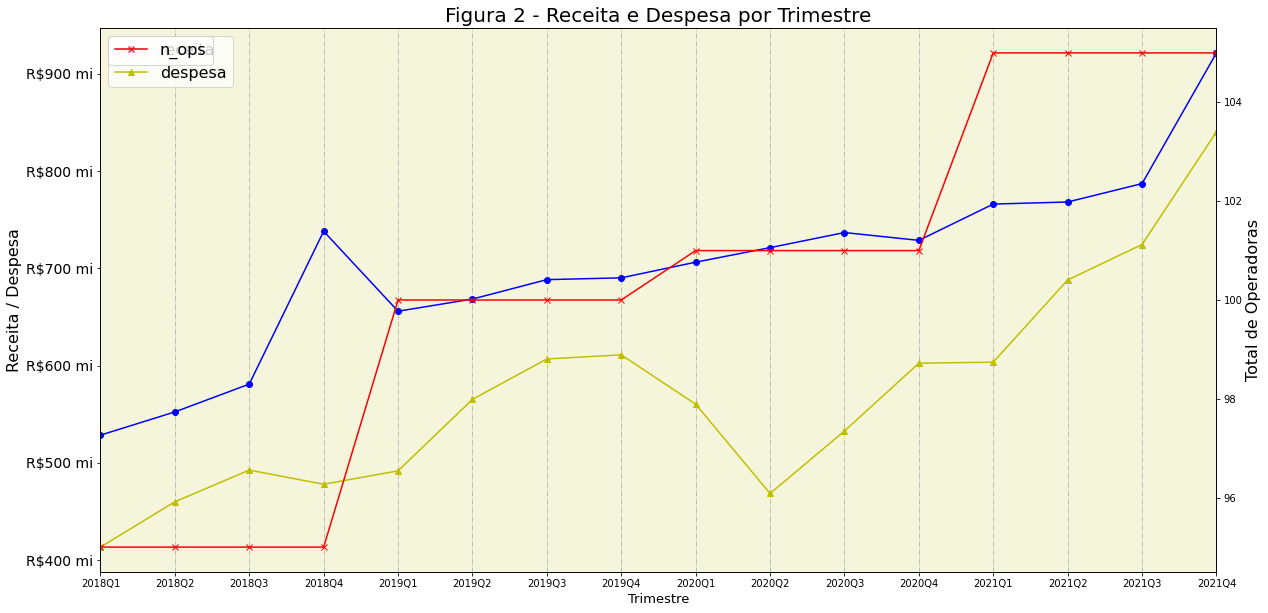

In [34]:
df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('ade_m_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [35]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
46,2018,335479,177.570,189.830
83,2018,367087,130.090,99.750
57,2018,347507,110.870,70.180
29,2018,319708,103.240,84.890
93,2018,386588,85.160,47.410


In [36]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

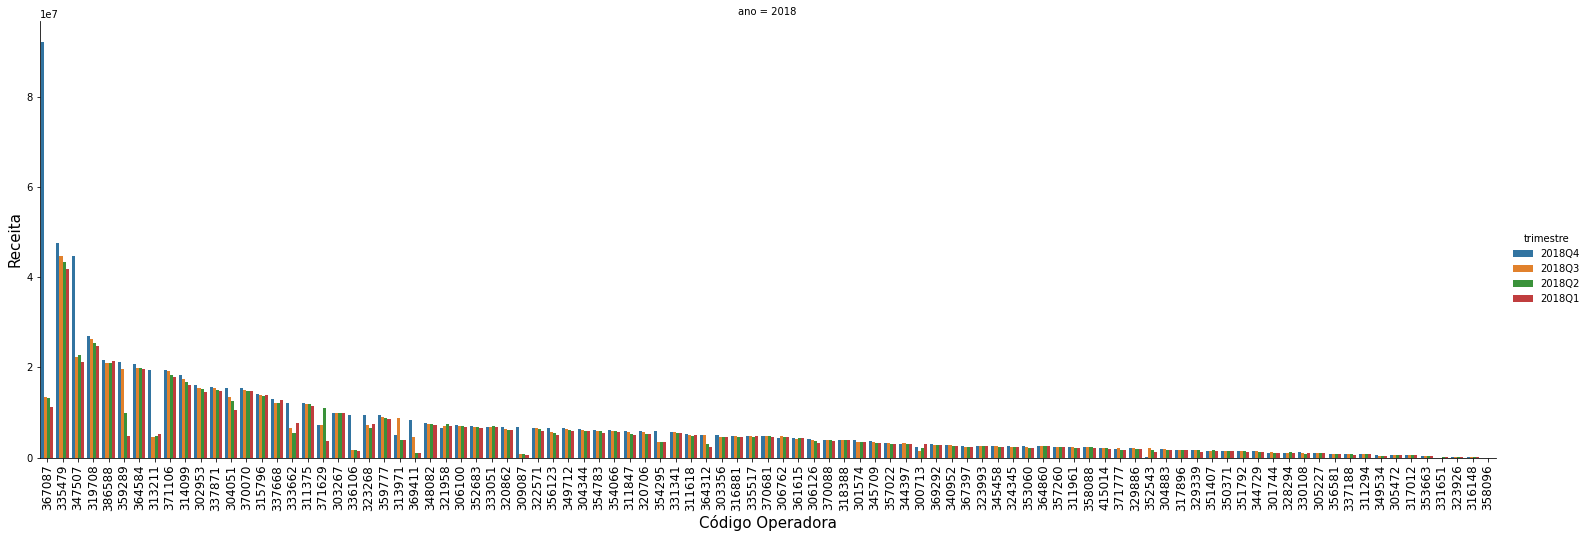

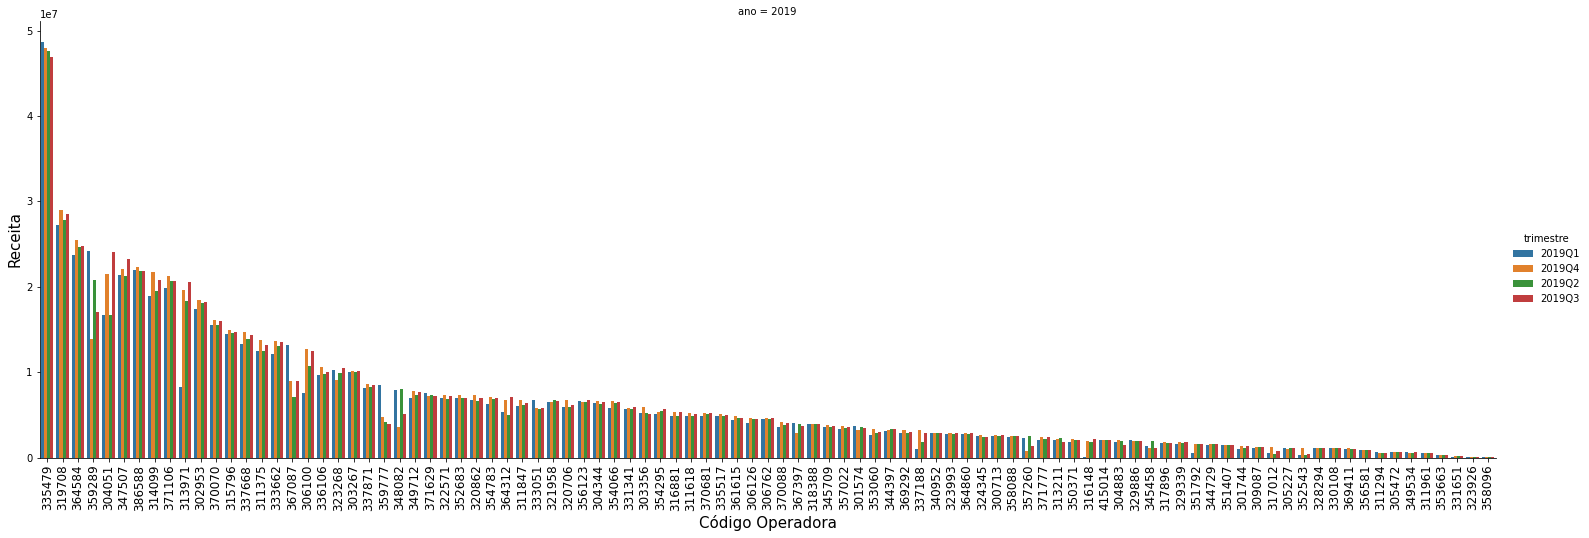

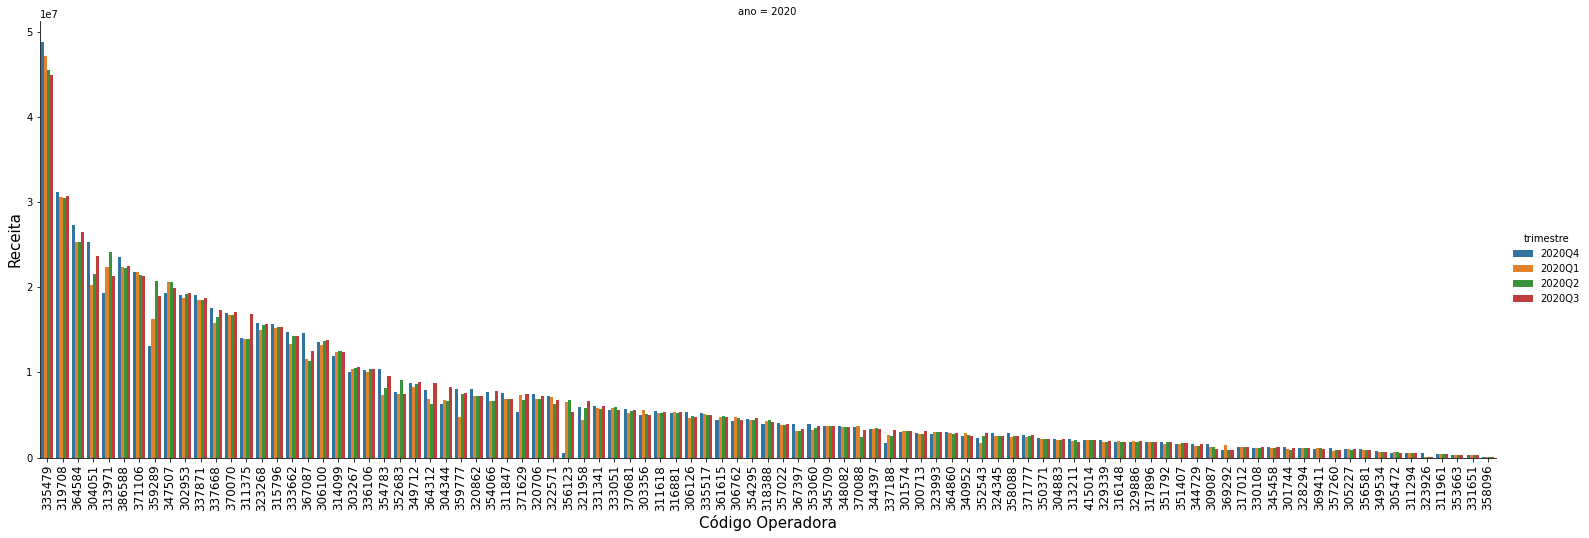

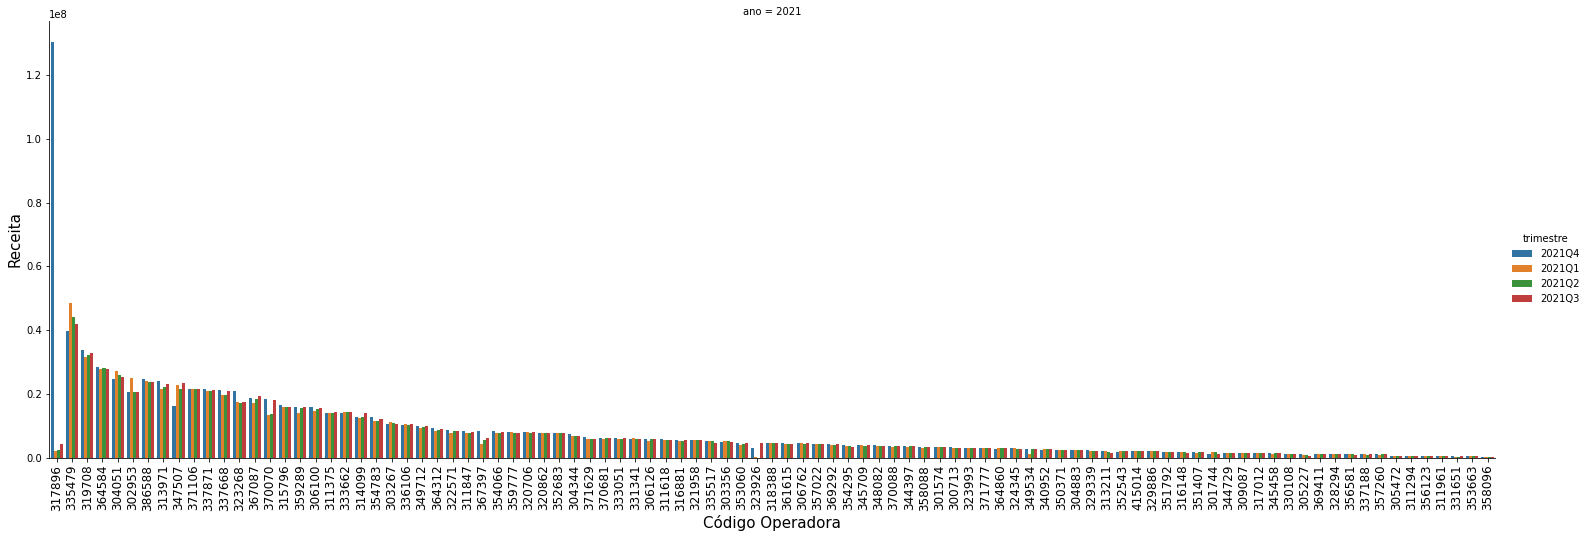

In [37]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

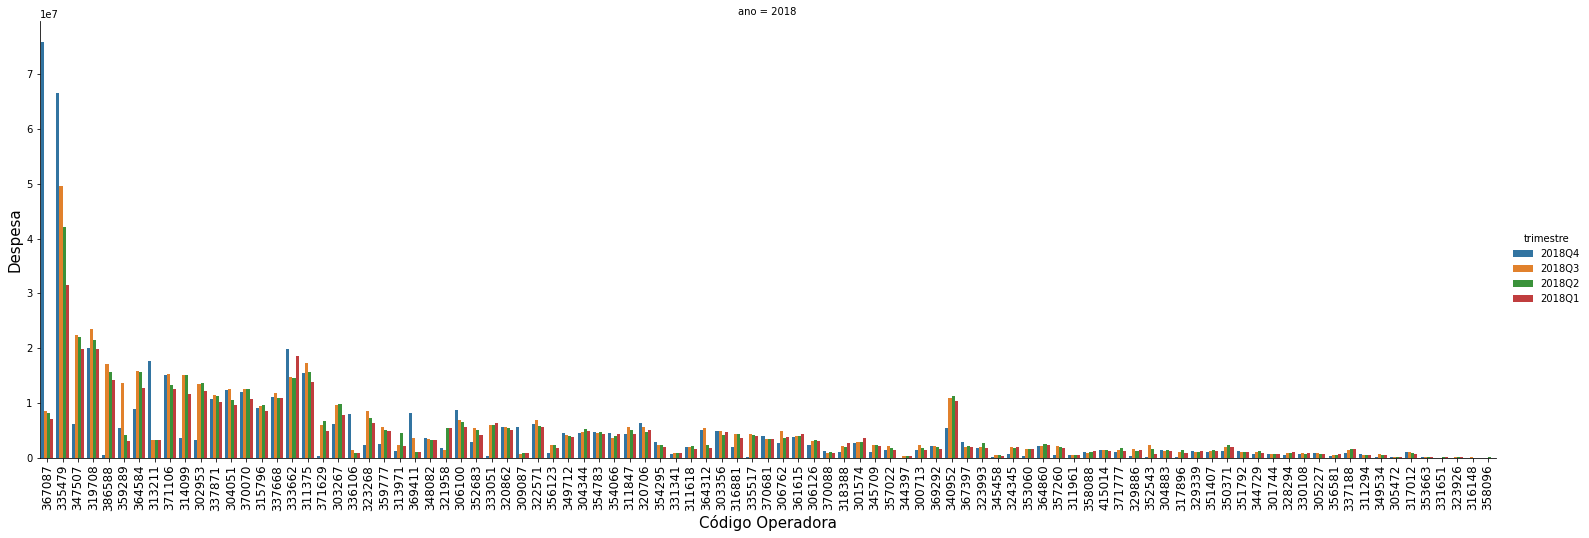

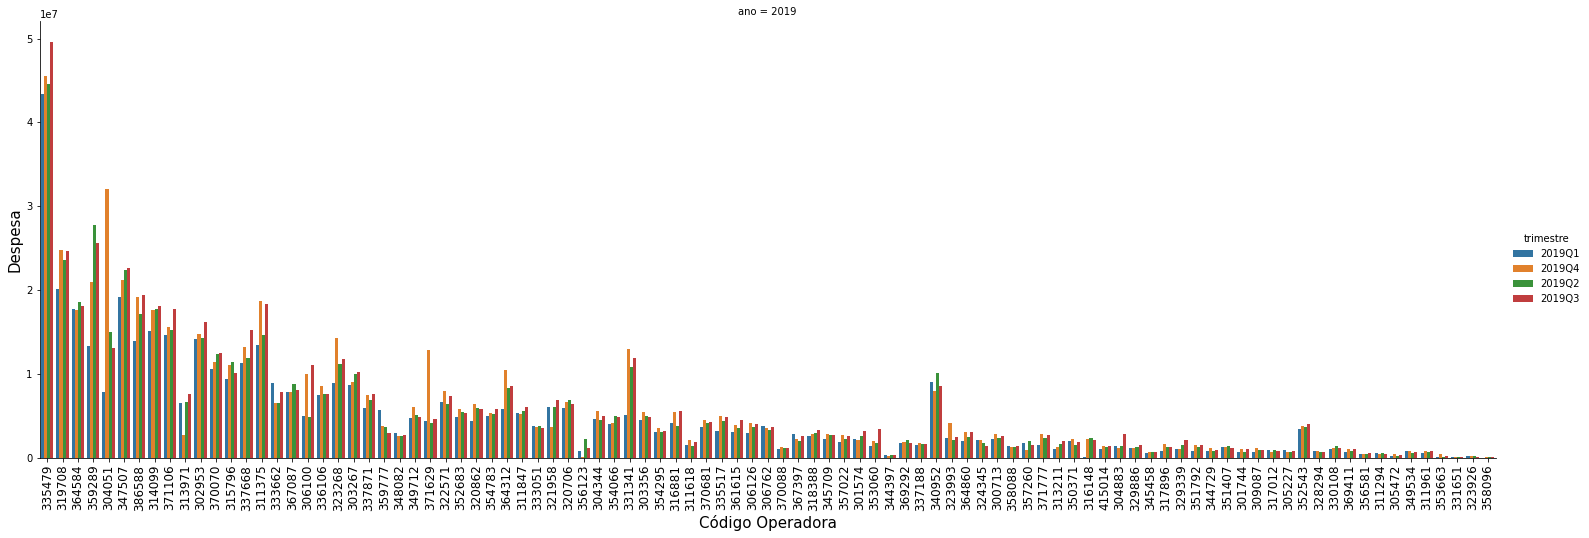

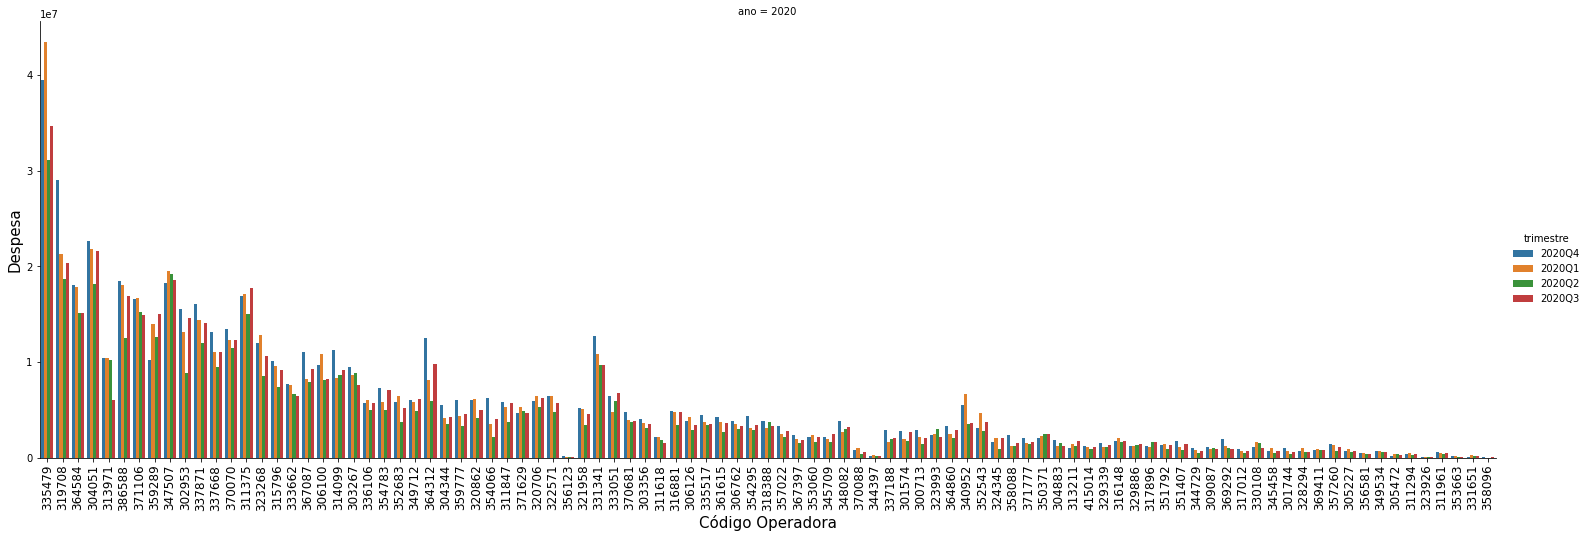

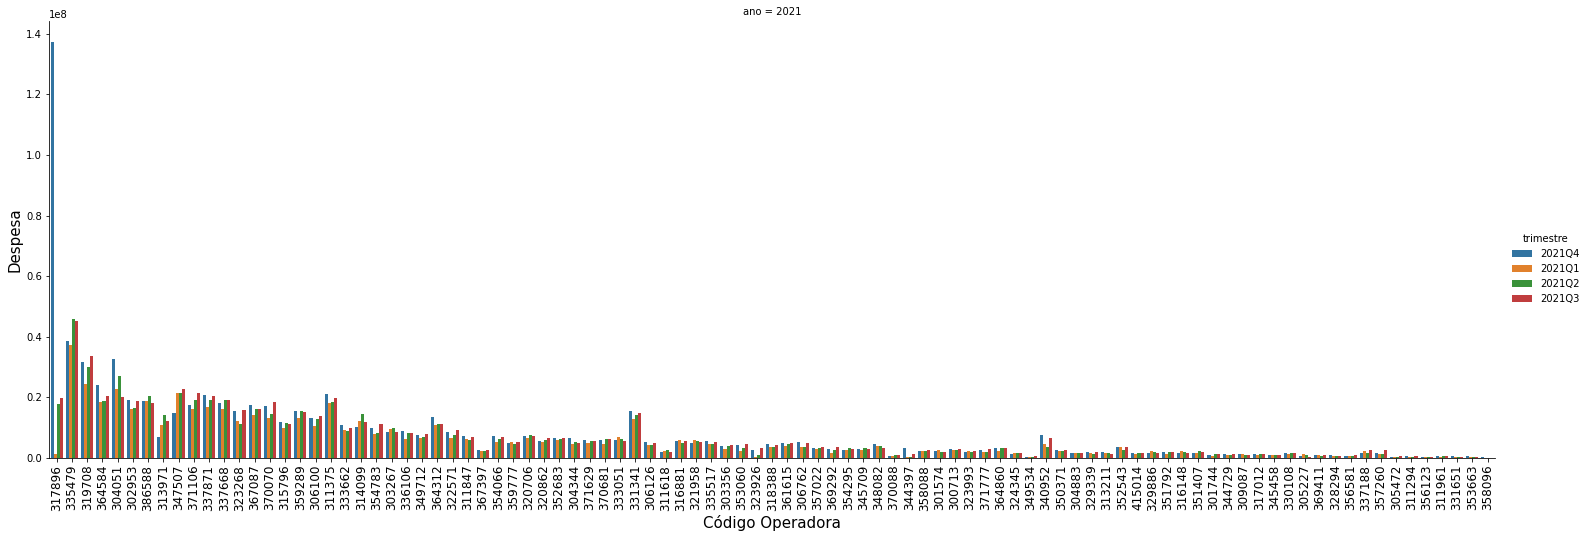

In [38]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [39]:
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg(  receita_total = ('receita','sum'),
                                                                                despesa_total = ('despesa','sum'))

ans_alterada17 = pd.merge(ans_alterada14,ans_alterada16, how='left', on=['ano','cd_ops'])

#diops_tcc_analise17 = diops_tcc_analise17[(diops_tcc_analise17['trimestre']=='2018Q4') | (diops_tcc_analise17['trimestre']=='2018Q3')]

ans_alterada17 = ans_alterada17[(ans_alterada17['ano']=='2018') | (ans_alterada17['ano']=='2021')]

ans_alterada17['pct_receita'] = ans_alterada17['receita'] / ans_alterada17['receita_total']

ans_alterada17['pct_despesa'] = ans_alterada17['despesa'] / ans_alterada17['despesa_total']

ans_alterada17.head()

,ano,cd_ops,trimestre,receita,despesa,receita_total,despesa_total,pct_receita,pct_despesa
0,2018,300713,2018Q1,2962073.620,1405863.510,8921963.390,7031803.050,0.332,0.200
1,2018,300713,2018Q2,2231365.780,1820915.150,8921963.390,7031803.050,0.250,0.259
2,2018,300713,2018Q3,1406682.200,2351203.340,8921963.390,7031803.050,0.158,0.334
3,2018,300713,2018Q4,2321841.790,1453821.050,8921963.390,7031803.050,0.260,0.207
4,2018,301574,2018Q1,3559709.440,3584395.420,14526854.160,11991381.480,0.245,0.299


In [40]:
stats_ans_alterada3 = ans_alterada17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.51])

stats_ans_alterada3

pct_receita                                     pct_despesa                                    
                     count  mean   std   min   50%   51%   max       count  mean   std   min   50%   51%   max
ano  trimestre                                                                                                
2018 2018Q1         95.000 0.230 0.047 0.065 0.242 0.242 0.429      95.000 0.242 0.070 0.044 0.241 0.242 0.580
     2018Q2         95.000 0.237 0.044 0.066 0.245 0.245 0.417      95.000 0.266 0.082 0.009 0.261 0.262 0.723
     2018Q3         95.000 0.249 0.045 0.090 0.252 0.252 0.413      95.000 0.272 0.076 0.034 0.265 0.270 0.523
     2018Q4         95.000 0.284 0.097 0.049 0.260 0.260 0.729      95.000 0.220 0.142 0.005 0.221 0.222 0.761
2021 2021Q1        105.000 0.240 0.037 0.014 0.247 0.247 0.290     105.000 0.219 0.055 0.007 0.221 0.222 0.390
     2021Q2        105.000 0.244 0.034 0.002 0.248 0.248 0.298     105.000 0.238 0.044 0.040 0.246 0.246 0.395
     2021Q3        105.000 0.252 0.043 0.030 0.250 0.251 0.606     105.000 0.264 0.047 0.112 0.266 0.266 0.472
     2021Q4        105.000 0.264 0.070 0.192 0.256 0.256 0.938     105.000 0.278 0.079 0.158 0.268 0.268 0.781

In [41]:
stats_ans_alterada4 = stats_ans_alterada3.reset_index(level=[0,1])

stats_ans_alterada4.columns = ['_'.join(col) for col in stats_ans_alterada4.columns.values]

stats_ans_alterada4 = stats_ans_alterada4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_51%', 'pct_despesa_51%']]

stats_ans_alterada4.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_receita_50%':'pct_receita_50',
                                      'pct_despesa_50%':'pct_despesa_50',
                                      'pct_receita_51%':'pct_receita_ref',
                                      'pct_despesa_51%':'pct_despesa_ref'}, inplace = True)

stats_ans_alterada4

,ano,trimestre,pct_receita_mean,pct_despesa_mean,pct_receita_50,pct_despesa_50,pct_receita_ref,pct_despesa_ref
0,2018,2018Q1,0.230,0.242,0.242,0.241,0.242,0.242
1,2018,2018Q2,0.237,0.266,0.245,0.261,0.245,0.262
2,2018,2018Q3,0.249,0.272,0.252,0.265,0.252,0.270
3,2018,2018Q4,0.284,0.220,0.260,0.221,0.260,0.222
4,2021,2021Q1,0.240,0.219,0.247,0.221,0.247,0.222
5,2021,2021Q2,0.244,0.238,0.248,0.246,0.248,0.246
6,2021,2021Q3,0.252,0.264,0.250,0.266,0.251,0.266
7,2021,2021Q4,0.264,0.278,0.256,0.268,0.256,0.268


In [42]:
ans_alterada18 = pd.merge(ans_alterada17,stats_ans_alterada4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

ans_alterada18['receita_mean'] = ans_alterada18['receita_total'] * ans_alterada18['pct_receita_50']

ans_alterada18['despesa_mean'] = ans_alterada18['despesa_total'] * ans_alterada18['pct_despesa_50']

ans_alterada18 = ans_alterada18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

ans_alterada18.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,300713,2018Q1,2155029.860,1696475.220
1,2018,300713,2018Q2,2182634.396,1835928.736
2,2018,300713,2018Q3,2249260.986,1863489.812
3,2018,300713,2018Q4,2317860.278,1551799.017
4,2018,301574,2018Q1,3508847.001,2893010.711


In [43]:
ans_alterada19 = pd.merge(ans_alterada17,stats_ans_alterada4, how='left', on=['ano','trimestre'])

ans_alterada19 = ans_alterada19[(ans_alterada19['pct_receita'] > ans_alterada19['pct_receita_50'])]

ans_alterada19 = ans_alterada19[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

ans_alterada19.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.620,1405863.510
1,2018,350371,2018Q3,1539777.820,1996181.780
2,2018,351407,2018Q2,1595537.040,1480577.400
3,2018,351407,2018Q3,1551172.330,1268447.790
4,2018,351792,2018Q2,1494379.770,1017883.440


In [44]:
ans_alterada20 = pd.merge(ans_alterada19,ans_alterada18, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada20 = ans_alterada20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

ans_alterada20.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,300713,2018Q1,2155029.860,1696475.220
1,2018,350371,2018Q3,1473380.580,1957031.988
2,2018,351407,2018Q2,1480178.137,1306018.120
3,2018,351407,2018Q3,1525361.711,1325624.144
4,2018,351792,2018Q2,1388567.483,1116517.078


In [45]:
ans_alterada21 = pd.merge(ans_alterada14,ans_alterada20, how='left', on=['ano','cd_ops','trimestre'])

#diops_tcc_analise21['receita_diff'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_mean']) / 4.0

#diops_tcc_analise21['despesa_diff'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_mean'])/ 4.0

ans_alterada21.fillna(0, inplace=True)

ans_alterada21['receita_corrigida'] = np.where(ans_alterada21['receita_mean'] == 0, ans_alterada21['receita'], ans_alterada21['receita_mean'])

ans_alterada21['despesa_corrigida'] = np.where(ans_alterada21['despesa_mean'] == 0, ans_alterada21['despesa'], ans_alterada21['despesa_mean'])

ans_alterada21['receita_diff_tri'] = (ans_alterada21['receita'] - ans_alterada21['receita_corrigida']) / 4.0

ans_alterada21['despesa_diff_tri'] = (ans_alterada21['despesa'] - ans_alterada21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

ans_alterada21.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada21.head()

,ano,cd_ops,trimestre,receita,despesa,receita_mean,despesa_mean,receita_corrigida,despesa_corrigida,receita_diff_tri,despesa_diff_tri
0,2018,300713,2018Q1,2962073.620,1405863.510,2155029.860,1696475.220,2155029.860,1696475.220,201760.940,-72652.928
258,2018,353060,2018Q3,2364952.430,1546449.830,2362376.117,1330008.514,2362376.117,1330008.514,644.078,54110.329
257,2018,353060,2018Q2,2254929.530,1503847.350,0.000,0.000,2254929.530,1503847.350,0.000,0.000
256,2018,353060,2018Q1,2099403.890,1625313.840,0.000,0.000,2099403.890,1625313.840,0.000,0.000
255,2018,352683,2018Q4,7036167.250,2811707.940,7033059.635,3839656.097,7033059.635,3839656.097,776.904,-256987.039


In [46]:
ans_alterada22 = ans_alterada21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

ans_alterada22 = ans_alterada22[ans_alterada22['receita_diff_tri']!=0]

ans_alterada22.head()

,ano,cd_ops,receita_diff_tri,despesa_diff_tri
0,2018,300713,214939.164,-100900.816
1,2018,301574,29807.071,166764.245
2,2018,301744,42112.753,-10837.591
3,2018,302953,111510.442,-907982.284
4,2018,303267,149844.394,229311.522


In [47]:
ans_alterada23 = ans_alterada21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

ans_alterada23.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada23.head()

,ano,cd_ops,trimestre,receita_corrigida,despesa_corrigida
0,2018,300713,2018Q1,2155029.860,1696475.220
258,2018,336106,2018Q2,1640781.960,929585.890
257,2018,300713,2018Q2,2182634.396,1835928.736
256,2018,300713,2018Q3,1406682.200,2351203.340
255,2018,300713,2018Q4,2317860.278,1551799.017


In [48]:
ans_alterada24 = pd.merge(ans_alterada23, ans_alterada22, how='left', on = ['ano','cd_ops'])

ans_alterada24.fillna(0, inplace=True)

ans_alterada24.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada24['receita'] = ans_alterada24['receita_corrigida'] + ans_alterada24['receita_diff_tri']

ans_alterada24['despesa'] = ans_alterada24['despesa_corrigida'] + ans_alterada24['despesa_diff_tri']

ans_alterada24 = ans_alterada24[['ano','cd_ops','trimestre','receita','despesa']]

#ans_alterada24[ans_alterada24['cd_ops']=='342084']

ans_alterada24.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2369969.024,1595574.404
258,2018,336106,2018Q3,3117674.743,2741792.760
257,2018,353060,2018Q3,2417254.447,1193012.153
256,2018,353060,2018Q2,2309807.861,1366850.989
255,2018,353060,2018Q1,2154282.221,1488317.479


In [49]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [50]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [51]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [52]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.667,4,3


In [53]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','trimestre','benef']]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','trimestre'],as_index=False).agg({'benef':'sum'})

sib_filtrada

,ano,cd_ops,trimestre,benef
0,2017,27,2017Q3,11173
1,2017,27,2017Q4,10584
2,2017,300012,2017Q3,747
3,2017,300012,2017Q4,719
4,2017,300713,2017Q3,3410
...,...,...,...,...
10227,2022,422771,2022Q1,462
10228,2022,422827,2022Q1,33
10229,2022,5711,2022Q1,116492
10230,2022,6246,2022Q1,228443


In [54]:
ans_alterada25 = pd.merge(ans_alterada24,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['port_ops'] = porte_operadora

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('ade_m_coopmed.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2018,300713,2018Q1,2369969.024,1595574.404,3419.000
1,2018,336106,2018Q3,3117674.743,2741792.760,5779.000
2,2018,353060,2018Q3,2417254.447,1193012.153,2277.000
3,2018,353060,2018Q2,2309807.861,1366850.989,2119.000
4,2018,353060,2018Q1,2154282.221,1488317.479,2025.000


In [55]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('ade_m_coopmed_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)

ans_alterada26 

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,560.040,436.200,594552.000,95,77.890
2018Q2,581.450,480.730,607081.000,95,82.680
2018Q3,604.070,508.230,612546.000,95,84.130
2018Q4,654.640,419.120,610208.000,95,64.020
2019Q1,655.970,491.880,653662.000,100,74.990
2019Q2,668.480,565.330,648265.000,100,84.570
2019Q3,688.430,606.900,643660.000,100,88.160
2019Q4,690.290,611.120,636258.000,100,88.530
2020Q1,706.390,560.410,641658.000,101,79.330


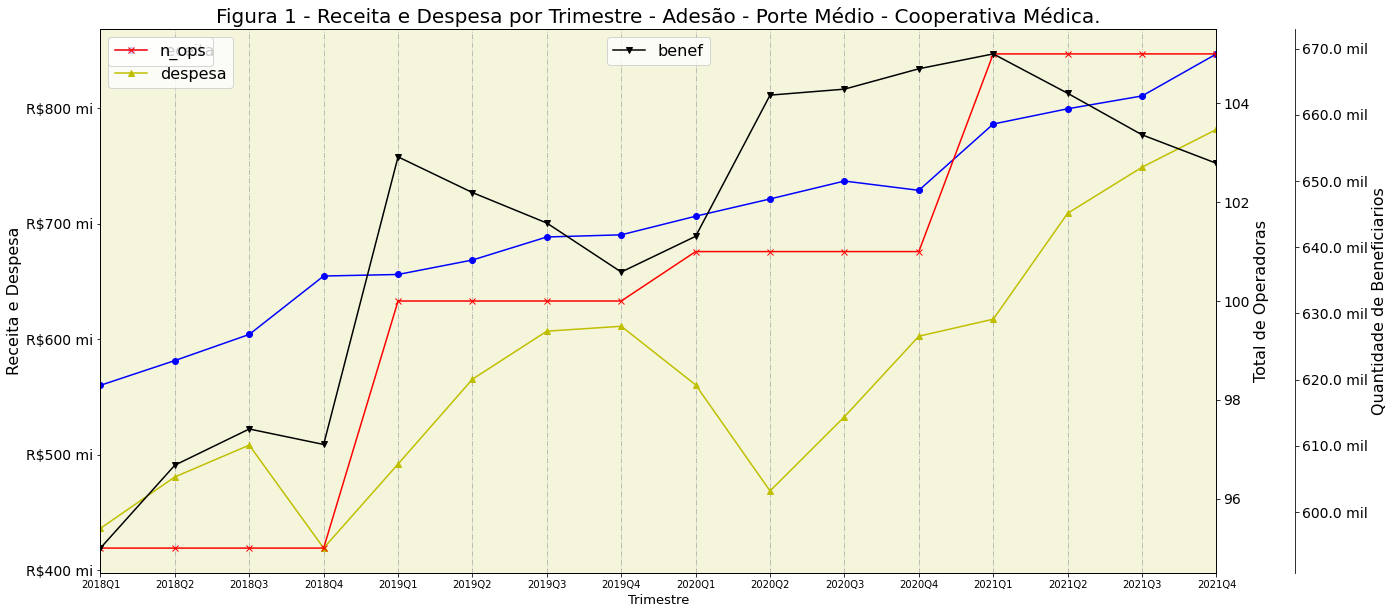

In [56]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesão - Porte Médio - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x/1e3) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('ade_m_coopmed_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [57]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada27 = ans_alterada25.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada27.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada27.head()

,ano,cd_ops,receita,despesa
46,2018,335479,177.570,189.830
83,2018,367087,130.090,99.750
57,2018,347507,110.870,70.180
29,2018,319708,103.240,84.890
93,2018,386588,85.160,47.410


In [58]:
ans_alterada_ops = ans_alterada27.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada25.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada28 =  ans_alterada25[i1.isin(i2)]

ans_alterada28.sort_values(by=['receita'], ascending=False, inplace=True)

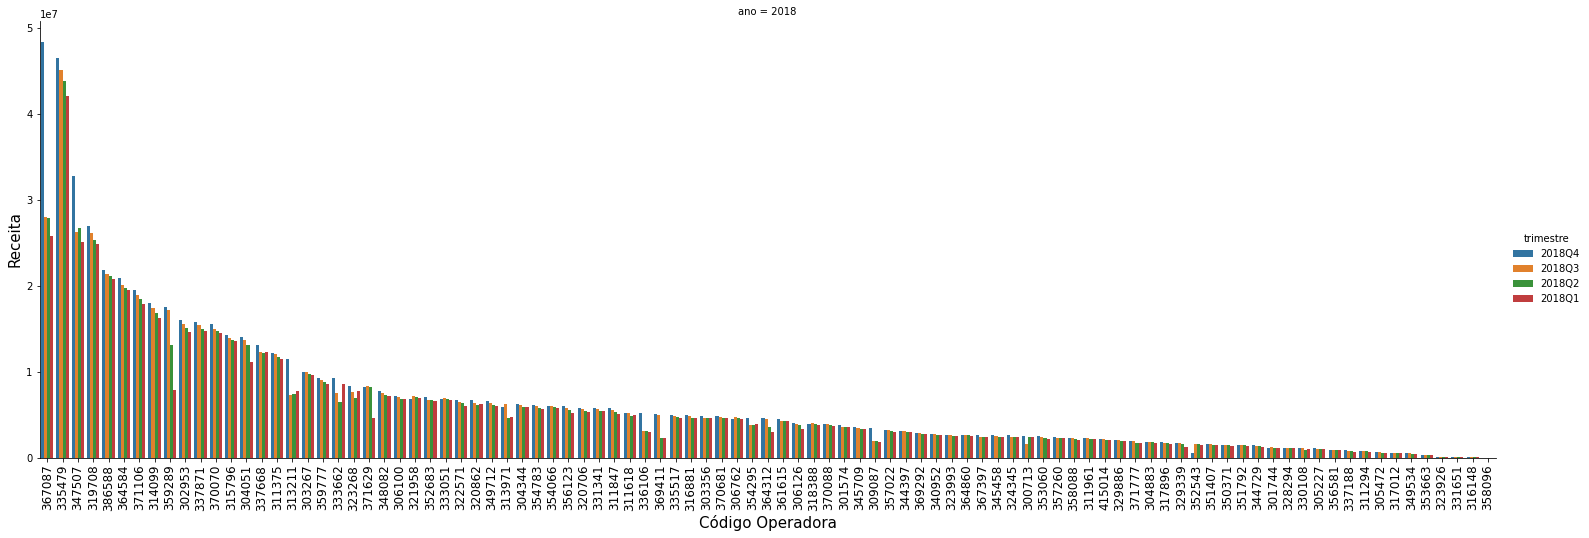

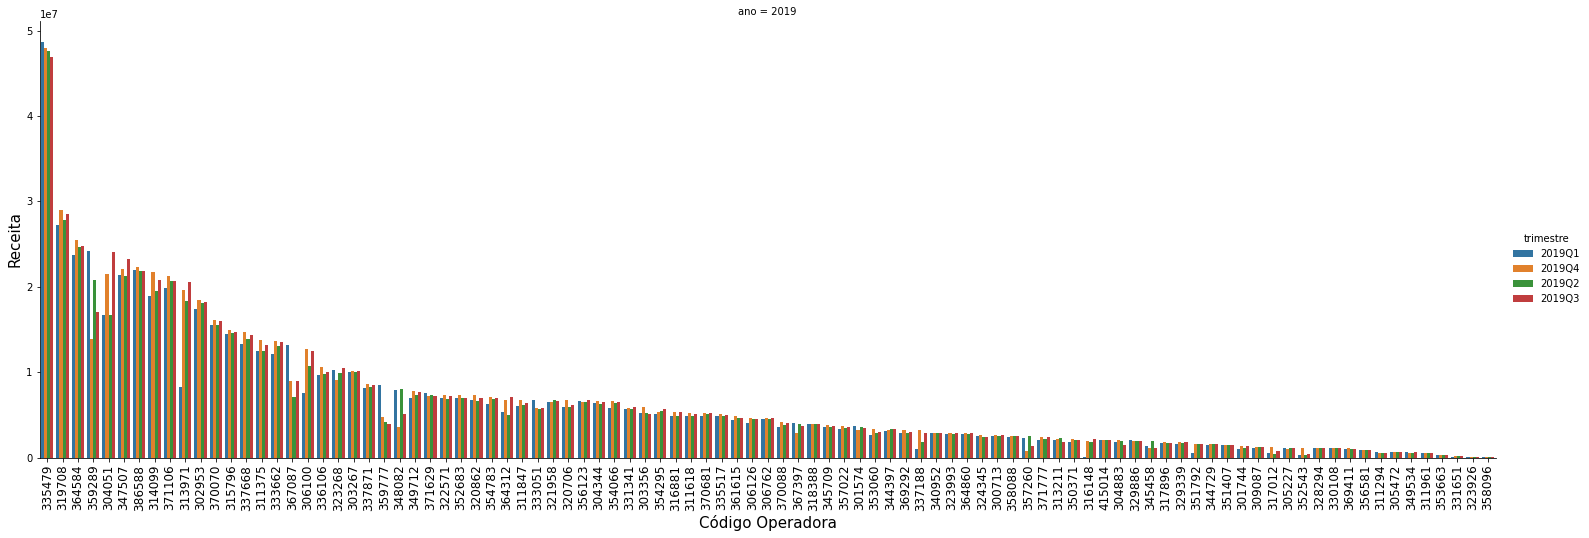

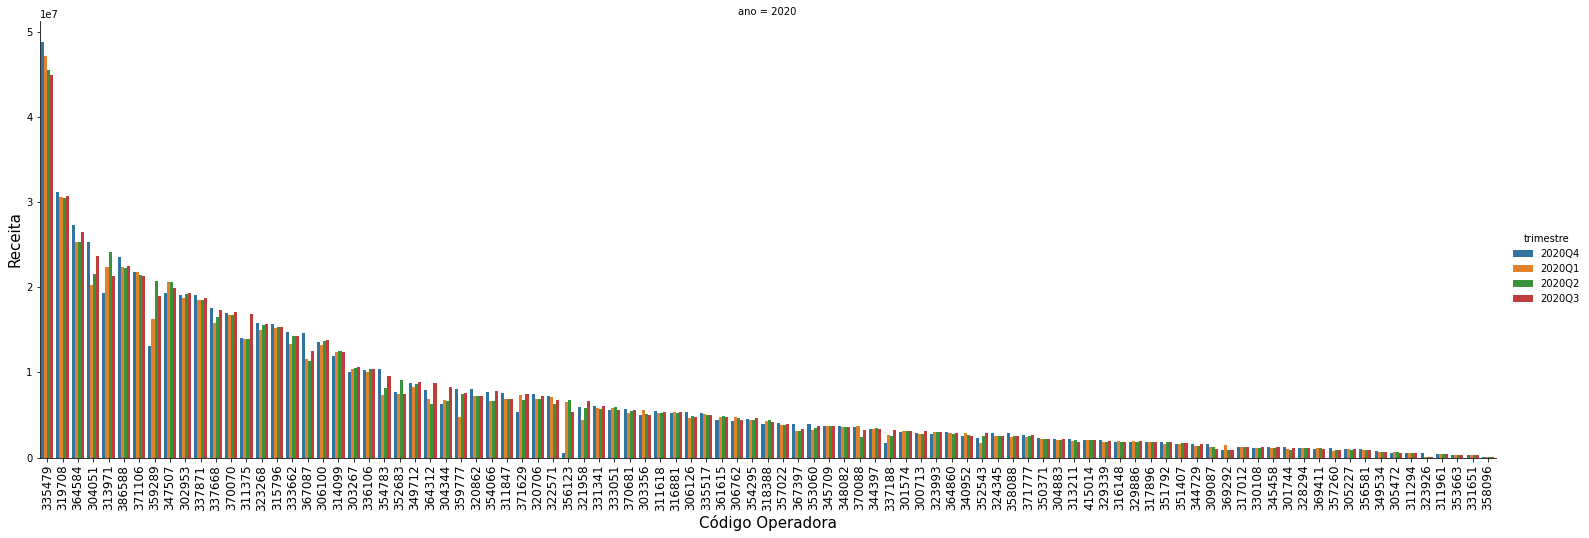

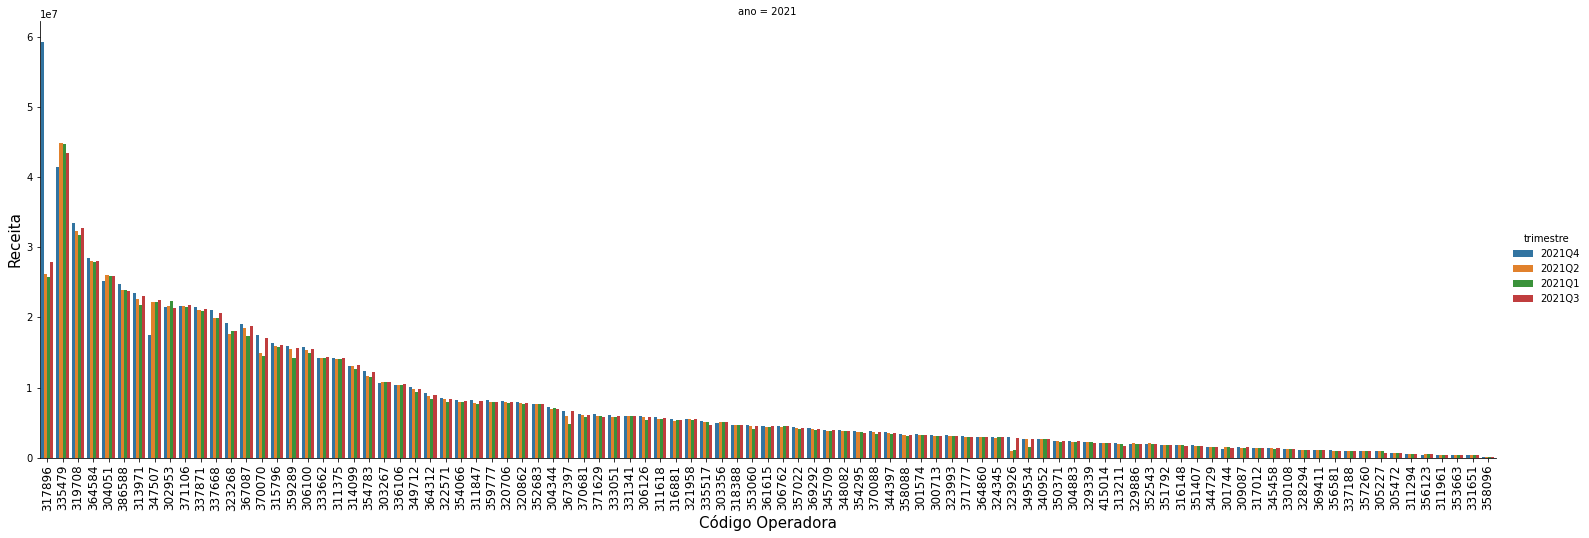

In [59]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

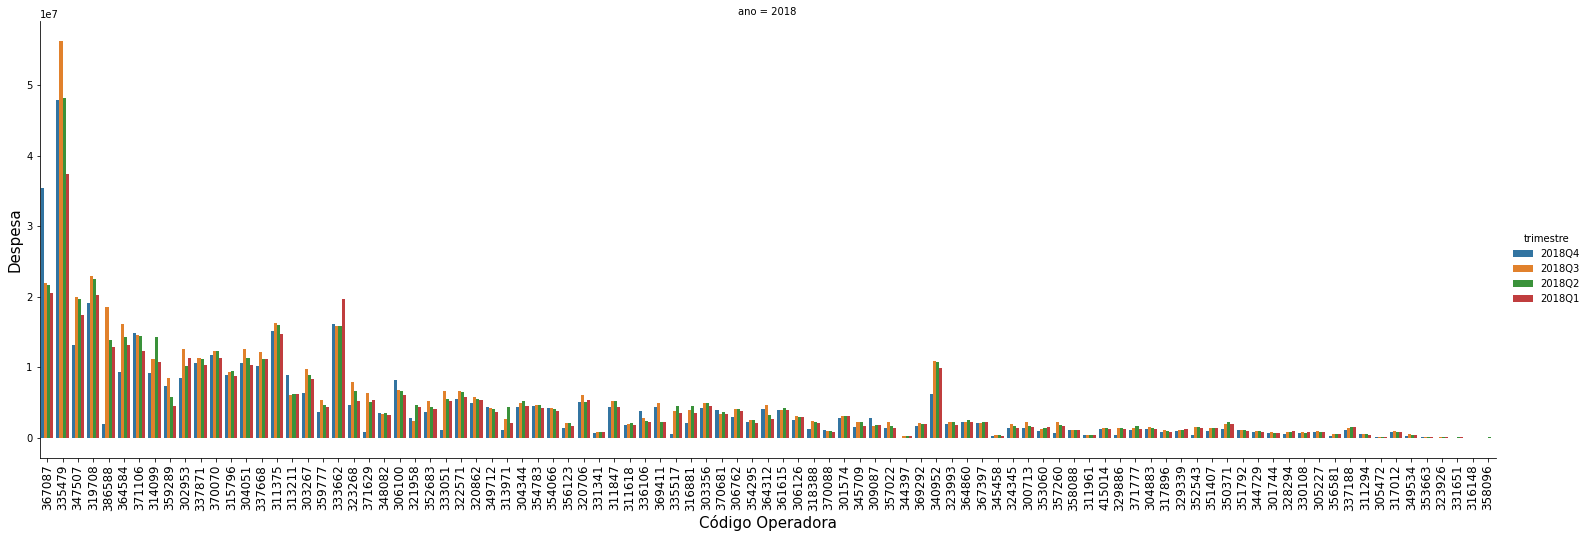

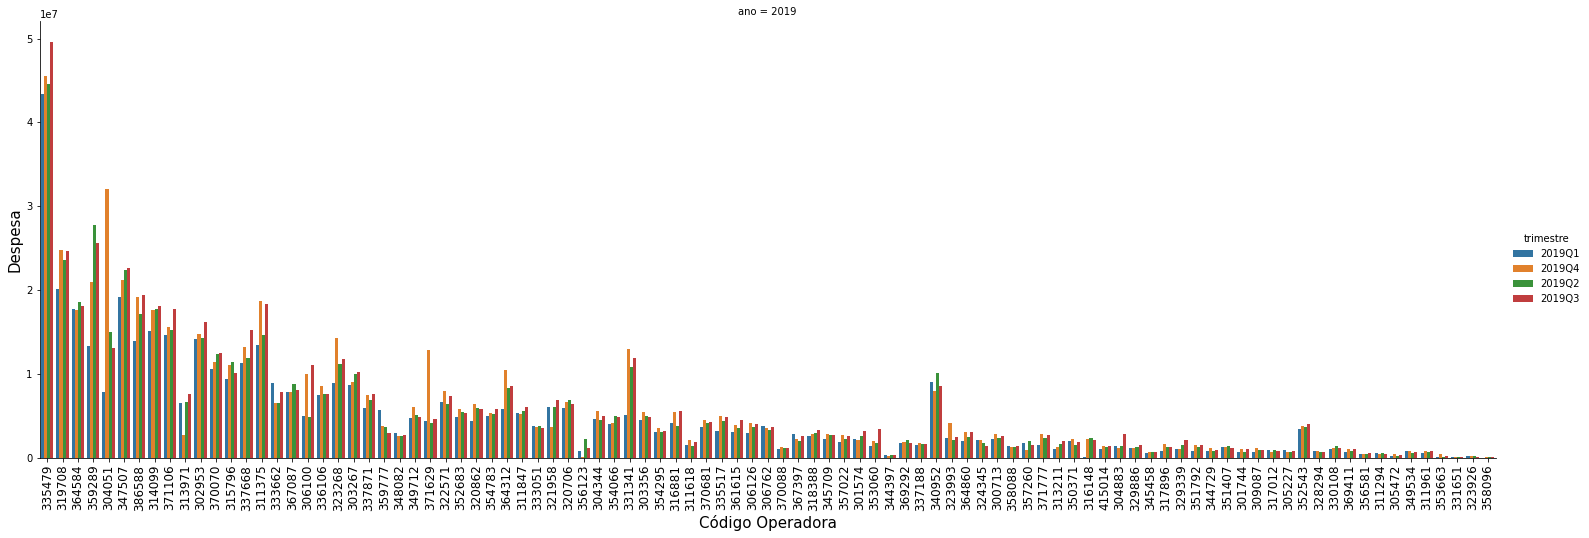

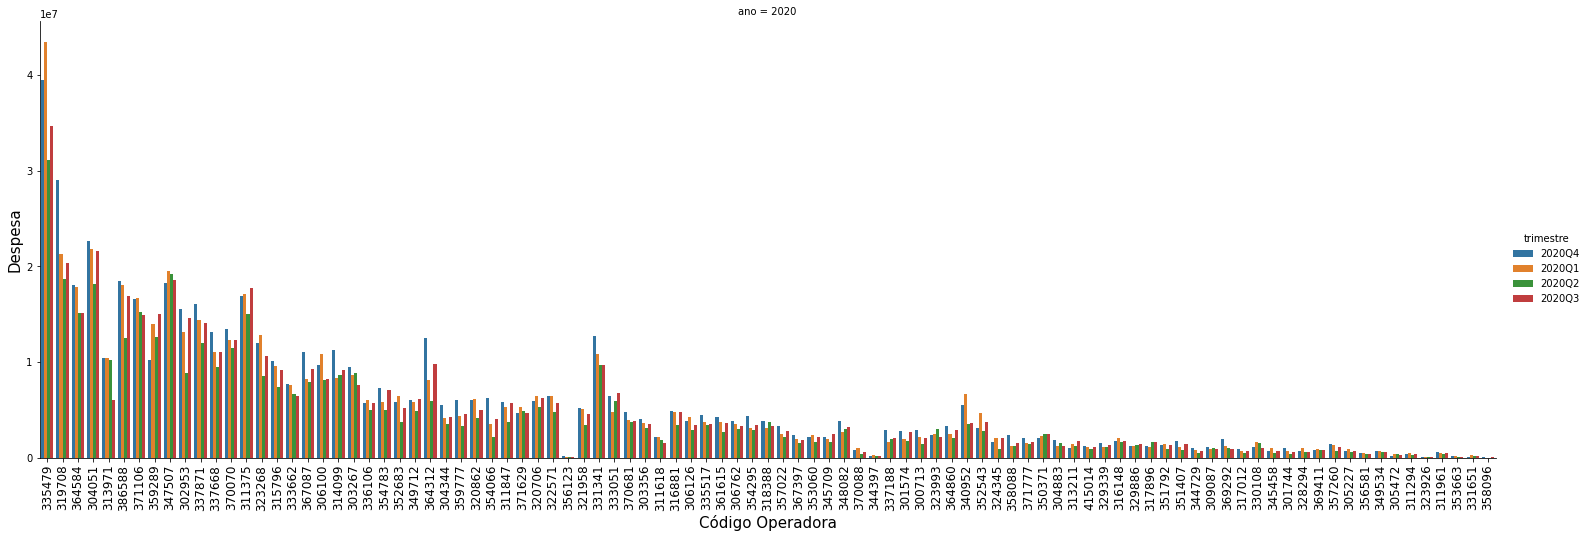

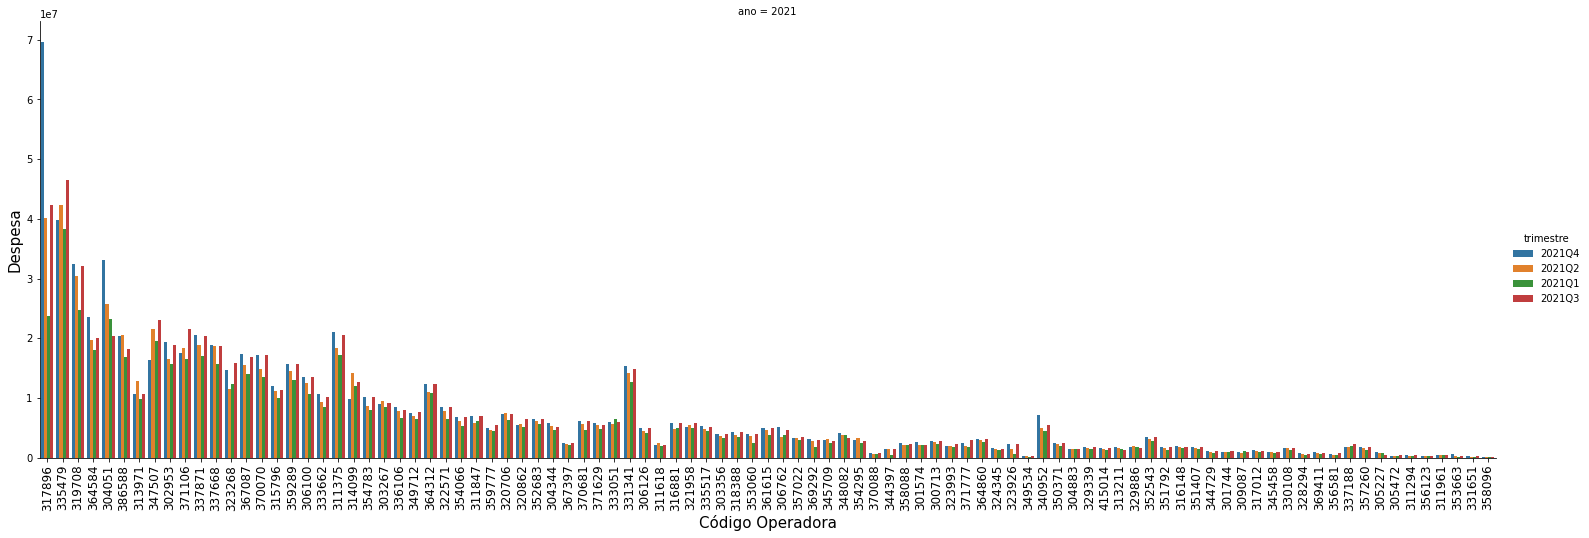

In [60]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()